In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import random
from imblearn.over_sampling import SMOTENC

from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

drive_path = '/content/drive/MyDrive/Kuliah/Tugas Akhir/Final Project Shared Folder'
data_path = "Dataset/Data Versioning/"
model_path = "Model/ML Model/"
data_version = "Trained_V2-3.csv"
base_url = "https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?CycleBeginYear=2017"
dataset_names = ['Demographics', 'Dietary', 'Examination', 'Laboratory', 'Questionnaire']

# Ingest Data

df_raw = pd.read_csv(os.path.join(drive_path, data_path+data_version), index_col = 0)
try:
  df_raw = df_raw.set_index('SEQN', drop=True)
  df_raw = df_raw.drop(columns = "Unnamed: 0")
except:
  pass

def get_categorical(df):
    categorical = []
    for col in df.columns.tolist():
        try:
            if len(df[col].unique().tolist()) < 20:
                categorical.append({
                    'desc': model_var[model_var['model_var_name'] ==  col]['desc'].values[0],
                    'column': col,
                    'possible_values': df[col].unique().tolist()}
                            )
        except Exception as error:
            if len(df[col].unique().tolist()) < 20:
                categorical.append({
                    'desc': None,
                    'column': col,
                    'possible_values': df[col].unique().tolist()})
            # print(f'{col} error: {error}')
    return categorical

X = df_raw.copy().drop(columns=['Quest16_MCQ160B'])
y = df_raw['Quest16_MCQ160B']

categorical_summary = get_categorical(X)
categorical_cols = [True if data_col in [col['column'] for col in categorical_summary] else False for data_col in X.columns.tolist()]
print(categorical_cols)

# Data Preparation For Model

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def prep_data(df):
  X = df_raw.copy().drop(columns=['Quest16_MCQ160B'])
  y = df_raw['Quest16_MCQ160B']

  y = y.replace({2: 0})
  y = y.replace({9: 0})

  y = y.astype(int)

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)


  # Instantiate the SMOTE oversampler
  smotenc = SMOTENC(
      categorical_features=categorical_cols,
      sampling_strategy='auto',
      random_state=37
    )

  # Apply SMOTE to generate synthetic samples
  X_resampled, y_resampled = smotenc.fit_resample(X_train, y_train)

  scaler = StandardScaler()
  X_resampled = scaler.fit_transform(X_resampled)
  X_val = scaler.transform(X_val)

  # X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
  # X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

  print("Train: ", X_resampled.shape, " ", y_resampled.shape)
  print("Val: ", X_val.shape, " ", y_val.shape)
  print("Column Used: ", X.columns.tolist())

  return X_resampled, X_val, y_resampled, y_val

X_train, X_val, y_train, y_val = prep_data(df_raw)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, False, True, True, False, True, True, False, True, True, True, True, False, True, True, False, True, True, False, False, True, True, False, True, False, False, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, False, True, True, True]
Train:  (7522, 85)   (7522,)
Val:  (1671, 85)   (1671,)
Column Used:  ['Dieta1_DRDINT', 'Dieta1_DR1TFIBE', 'Quest21_SLQ300', 'Quest19_PAD660', 'Quest19_PAQ635', 'Dieta1_DR1TCHOL', 'Quest19_PAQ655', 'Dieta1_DR1TSFAT', 'Dieta1_DR1TKCAL', 'Exami2_BMXBMI', 'Dieta1_DR1TSUGR', 'Quest21_SLQ320', 'Quest21_SLQ330', 'Quest19_PAD615', 'Quest21_SLD012', 'Quest21_SLD013', 'Dieta1_DR1DAY', 'Quest6_DED120', 'Quest19_PAQ610', 'Quest6_DED125', 'Dieta1_DR1TPROT', 'Quest19_PAQ640', 'Dieta

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, f1_score, roc_auc_score

logistic_regression = LogisticRegression()

logistic_regression.fit(X_train, y_train)

print("Train Score:")
print(logistic_regression.score(X_train, y_train))
print("Validation Score:")
print(logistic_regression.score(X_val, y_val))

y_pred = logistic_regression.predict(X_val)
print(classification_report(y_val, y_pred))


f1score = f1_score(y_val, y_pred, average='weighted')
roc_auc = roc_auc_score(y_val, y_pred, average='weighted')

print("F1Score:", f1score)
print("ROC AUC:", roc_auc)

Train Score:
0.9508109545333688
Validation Score:
0.9138240574506283
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1607
           1       0.19      0.39      0.26        64

    accuracy                           0.91      1671
   macro avg       0.58      0.66      0.61      1671
weighted avg       0.94      0.91      0.93      1671

F1Score: 0.9275794826454794
ROC AUC: 0.6626429293714997


In [ ]:
logistic_regression = LogisticRegression()

param_grid = {
    'C': [0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg']
}

grid_search = GridSearchCV(logistic_regression, param_grid, cv=5)
grid_search.fit(X_train, y_train)

results = grid_search.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print("Hyperparameters:", params)
    print("Mean Score:", mean_score)
    print()

print("Best Params")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_

print("Train Score:")
print(best_model.score(X_train, y_train))
print("Validation Score:")
print(best_model.score(X_val, y_val))

y_pred = best_model.predict(X_val)
print(classification_report(y_val, y_pred))

f1score = f1_score(y_val, y_pred, average='micro')
roc_auc = roc_auc_score(y_val, y_pred, average='micro')

print("F1Score:", f1score)
print("ROC AUC:", roc_auc)

Hyperparameters: {'C': 0.1, 'solver': 'liblinear'}
Mean Score: 0.9416408955962396

Hyperparameters: {'C': 0.1, 'solver': 'saga'}
Mean Score: 0.9424387679366649

Hyperparameters: {'C': 0.1, 'solver': 'lbfgs'}
Mean Score: 0.9431033964798191

Hyperparameters: {'C': 0.1, 'solver': 'newton-cg'}
Mean Score: 0.9431033964798191

Hyperparameters: {'C': 1, 'solver': 'liblinear'}
Mean Score: 0.9439013571782002

Hyperparameters: {'C': 1, 'solver': 'saga'}
Mean Score: 0.942439121368488

Hyperparameters: {'C': 1, 'solver': 'lbfgs'}
Mean Score: 0.9437683784547961

Hyperparameters: {'C': 1, 'solver': 'newton-cg'}
Mean Score: 0.9437683784547961

Hyperparameters: {'C': 10, 'solver': 'liblinear'}
Mean Score: 0.944300293348413

Hyperparameters: {'C': 10, 'solver': 'saga'}
Mean Score: 0.9424390330105323

Hyperparameters: {'C': 10, 'solver': 'lbfgs'}
Mean Score: 0.944300293348413

Hyperparameters: {'C': 10, 'solver': 'newton-cg'}
Mean Score: 0.944300293348413

Hyperparameters: {'C': 100, 'solver': 'liblinea

In [ ]:
best_hyperparameters = grid_search.cv_results_['params'][np.argmax(grid_search.cv_results_['rank_test_score'] == np.min(grid_search.cv_results_['rank_test_score']))]

print("Best Performing Hyperparameters:", best_hyperparameters)

logistic_regression = LogisticRegression(**best_hyperparameters)

logistic_regression.fit(X_train, y_train)

print("Train Score:")
print(logistic_regression.score(X_train, y_train))
print("Validation Score:")
print(logistic_regression.score(X_val, y_val))

y_pred = logistic_regression.predict(X_val)
print(classification_report(y_val, y_pred))


f1score = f1_score(y_val, y_pred, average='weighted')
roc_auc = roc_auc_score(y_val, y_pred, average='weighted')

print("F1Score:", f1score)
print("ROC AUC:", roc_auc)

Best Performing Hyperparameters: {'C': 10, 'solver': 'liblinear'}
Train Score:
0.9510768412656209
Validation Score:
0.9138240574506283
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1607
           1       0.19      0.39      0.26        64

    accuracy                           0.91      1671
   macro avg       0.58      0.66      0.61      1671
weighted avg       0.94      0.91      0.93      1671

F1Score: 0.9275794826454794
ROC AUC: 0.6626429293714997


In [ ]:
worst_hyperparameters = grid_search.cv_results_['params'][np.argmax(grid_search.cv_results_['rank_test_score'] == np.max(grid_search.cv_results_['rank_test_score']))]

print("Worst Performing Hyperparameters:", worst_hyperparameters)

logistic_regression = LogisticRegression(**worst_hyperparameters)

logistic_regression.fit(X_train, y_train)

print("Train Score:")
print(logistic_regression.score(X_train, y_train))
print("Validation Score:")
print(logistic_regression.score(X_val, y_val))

y_pred = logistic_regression.predict(X_val)
print(classification_report(y_val, y_pred))

f1score = f1_score(y_val, y_pred, average='weighted')
roc_auc = roc_auc_score(y_val, y_pred, average='weighted')

print("F1Score:", f1score)
print("ROC AUC:", roc_auc)

Worst Performing Hyperparameters: {'C': 0.1, 'solver': 'liblinear'}
Train Score:
0.947487370380218
Validation Score:
0.9126271693596649
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1607
           1       0.19      0.41      0.26        64

    accuracy                           0.91      1671
   macro avg       0.58      0.67      0.61      1671
weighted avg       0.95      0.91      0.93      1671

F1Score: 0.9270991997258666
ROC AUC: 0.6695220130678283


In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, f1_score, roc_auc_score, accuracy_score


np.random.seed(37)
random.seed(37)

lr_classifier = LogisticRegression(C=10, solver='liblinear')

lr_classifier.fit(X_train, y_train)

print("Train Score:")
print(lr_classifier.score(X_train, y_train))
print("Validation Score:")
print(lr_classifier.score(X_val, y_val))

y_pred = lr_classifier.predict(X_val)
print(classification_report(y_val, y_pred))

accuracy = accuracy_score(y_val, y_pred)
f1score = f1_score(y_val, y_pred, average='weighted')
roc_auc = roc_auc_score(y_val, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("F1Score:", f1score)
print("ROC AUC:", roc_auc)

Train Score:
0.9510768412656209
Validation Score:
0.9138240574506283
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1607
           1       0.19      0.39      0.26        64

    accuracy                           0.91      1671
   macro avg       0.58      0.66      0.61      1671
weighted avg       0.94      0.91      0.93      1671

Accuracy: 0.9138240574506283
F1Score: 0.9275794826454794
ROC AUC: 0.6626429293714997


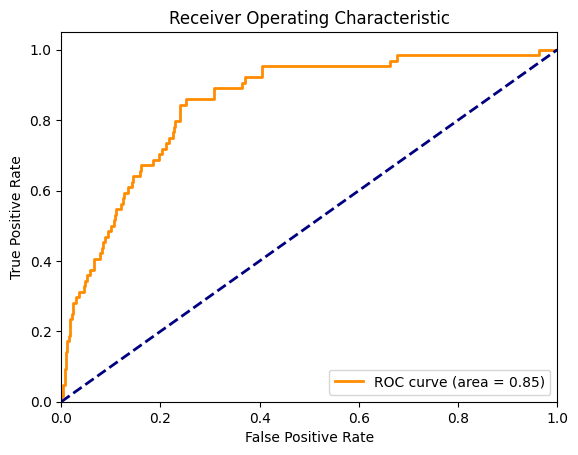

Optimal Threshold: 0.022452018248043847
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      1607
           1       0.12      0.86      0.21        64

    accuracy                           0.75      1671
   macro avg       0.56      0.80      0.53      1671
weighted avg       0.96      0.75      0.83      1671

ROC AUC Score: 0.8484365276913504


In [4]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

y_pred_prob = lr_classifier.predict_proba(X_val)[:, 1]

# Assuming y_val are the true labels and y_pred_prob are the predicted probabilities
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = roc_auc_score(y_val, y_pred_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Find the optimal threshold
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold}')

# Apply the optimal threshold
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

# Evaluate performance at the optimal threshold
print(classification_report(y_val, y_pred_optimal))
print(f'ROC AUC Score: {roc_auc}')

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, f1_score, roc_auc_score, accuracy_score


np.random.seed(37)
random.seed(37)

lr_classifier = LogisticRegression(C=10, solver='liblinear')

lr_classifier.fit(X_train, y_train)

print("Train Score:")
print(lr_classifier.score(X_train, y_train))
print("Validation Score:")
print(lr_classifier.score(X_val, y_val))

y_proba = lr_classifier.predict_proba(X_val)
y_pred = [1 if preds[1] >= optimal_threshold else 0 for preds in y_proba]
print(classification_report(y_val, y_pred))

accuracy = accuracy_score(y_val, y_pred)
f1score = f1_score(y_val, y_pred, average='weighted')
roc_auc = roc_auc_score(y_val, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("F1Score:", f1score)
print("ROC AUC:", roc_auc)

Train Score:
0.9510768412656209
Validation Score:
0.9138240574506283
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      1607
           1       0.12      0.86      0.21        64

    accuracy                           0.75      1671
   macro avg       0.56      0.80      0.53      1671
weighted avg       0.96      0.75      0.83      1671

Accuracy: 0.7522441651705566
F1Score: 0.8284538594271831
ROC AUC: 0.8036762990043559
